In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.special import inv_boxcox

In [2]:
import io
df = pd.read_csv('U.S. Renewable Energy Consumption.csv')
print(df)

      Year  Month          Sector  Hydroelectric Power  Geothermal Energy  \
0     1973      1      Commerical                0.000              0.000   
1     1973      1  Electric Power                0.000              0.490   
2     1973      1      Industrial                1.040              0.000   
3     1973      1     Residential                0.000              0.000   
4     1973      1  Transportation                0.000              0.000   
...    ...    ...             ...                  ...                ...   
3060  2024      1      Commerical                0.073              1.669   
3061  2024      1  Electric Power                0.000              4.667   
3062  2024      1      Industrial                0.308              0.356   
3063  2024      1     Residential                0.000              3.354   
3064  2024      1  Transportation                0.000              0.000   

      Solar Energy  Wind Energy  Wood Energy  Waste Energy  \
0            

In [3]:
# Display basic info
print(df.info())

# Convert Year and Month to a datetime index
df['Date'] = pd.to_datetime(df[['Year', 'Month']].astype(str).agg('-'.join, axis=1))
df.set_index('Date', inplace=True)

# Keep only the Electric Power sector data
df = df[df['Sector'] == 'Electric Power']

# Drop unnecessary columns
df = df.drop(columns=['Year', 'Month', 'Sector', 'Solar Energy', 'Wind Energy', 'Hydroelectric Power', 'Geothermal Energy', 'Wood Energy', 'Waste Energy', 'Fuel Ethanol, Excluding Denaturant', 'Biomass Losses and Co-products','Biomass Energy', 'Renewable Diesel Fuel', 'Other Biofuels', 'Conventional Hydroelectric Power', 'Biodiesel'])

# Display the first few rows
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3065 entries, 0 to 3064
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Year                                3065 non-null   int64  
 1   Month                               3065 non-null   int64  
 2   Sector                              3065 non-null   object 
 3   Hydroelectric Power                 3065 non-null   float64
 4   Geothermal Energy                   3065 non-null   float64
 5   Solar Energy                        3065 non-null   float64
 6   Wind Energy                         3065 non-null   float64
 7   Wood Energy                         3065 non-null   float64
 8   Waste Energy                        3065 non-null   float64
 9   Fuel Ethanol, Excluding Denaturant  3065 non-null   float64
 10  Biomass Losses and Co-products      3065 non-null   float64
 11  Biomass Energy                      3065 no

In [4]:
# Check for missing values
print(df.isnull().sum())
df

Total Renewable Energy    0
dtype: int64


,Total Renewable Energy
Date,
1973-01-01,89.223
1973-02-01,79.331
1973-03-01,88.046
1973-04-01,82.917
1973-05-01,85.357
...,...
2023-09-01,236.191
2023-10-01,261.855
2023-11-01,251.641


In [5]:
# Detect and remove outliers using Interquartile Range (IQR)
#Q1 = df.quantile(0.25)
#Q3 = df.quantile(0.75)
#IQR = Q3 - Q1
#df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [6]:
df

,Total Renewable Energy
Date,
1973-01-01,89.223
1973-02-01,79.331
1973-03-01,88.046
1973-04-01,82.917
1973-05-01,85.357
...,...
2023-09-01,236.191
2023-10-01,261.855
2023-11-01,251.641


In [7]:
def test_stationarity(timeseries, column_name):
    """ Test for stationarity in a time series while handling constant columns """
    if timeseries.nunique() == 1:  # Check if all values are the same
        print(f"Skipping {column_name}: The series is constant.")
        return

    result = adfuller(timeseries.dropna())  # Drop NaNs before running ADF
    print(f"ADF Statistic for {column_name}: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():  # result[4] contains critical values
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print(f"{column_name} is stationary.\n")
    else:
        print(f"{column_name} is non-stationary and requires differencing.\n")

# Apply stationarity test to the 'Total Renewable' column
test_stationarity(df['Total Renewable Energy'], 'Total Renewable Energy')

ADF Statistic for Total Renewable Energy: 0.6539376266791662
p-value: 0.988872331547583
Critical Values:
   1%: -3.441388211993052
   5%: -2.8664097967491498
   10%: -2.569363480686392
Total Renewable Energy is non-stationary and requires differencing.



In [8]:
# Import packages
from scipy.stats import boxcox

# Make the target variance stationary
df['Boxcox'], lam = boxcox(df['Total Renewable Energy'])

df['Diff'] = df['Boxcox'].diff()

In [9]:
lam

-0.4179508579342307

In [10]:
df.dropna()

,Total Renewable Energy,Boxcox,Diff
Date,,,
1973-02-01,79.331,2.008033,-0.018432
1973-03-01,88.046,2.024428,0.016394
1973-04-01,82.917,2.015074,-0.009353
1973-05-01,85.357,2.019623,0.004549
1973-06-01,81.835,2.012996,-0.006627
...,...,...,...
2023-09-01,236.191,2.148863,-0.010944
2023-10-01,261.855,2.159149,0.010286
2023-11-01,251.641,2.155234,-0.003915


In [11]:
test_stationarity(df['Boxcox'], 'Boxcox')
test_stationarity(df['Diff'], 'Diff')

ADF Statistic for Boxcox: -0.5309888269193737
p-value: 0.885826063129745
Critical Values:
   1%: -3.4414256033746606
   5%: -2.8664262627821473
   10%: -2.569372254520843
Boxcox is non-stationary and requires differencing.

ADF Statistic for Diff: -7.541279549039633
p-value: 3.372967832620067e-11
Critical Values:
   1%: -3.441444394224128
   5%: -2.8664345376276454
   10%: -2.569376663737217
Diff is stationary.



**PACF & ACF**

ACF and PACF for Diff_Log


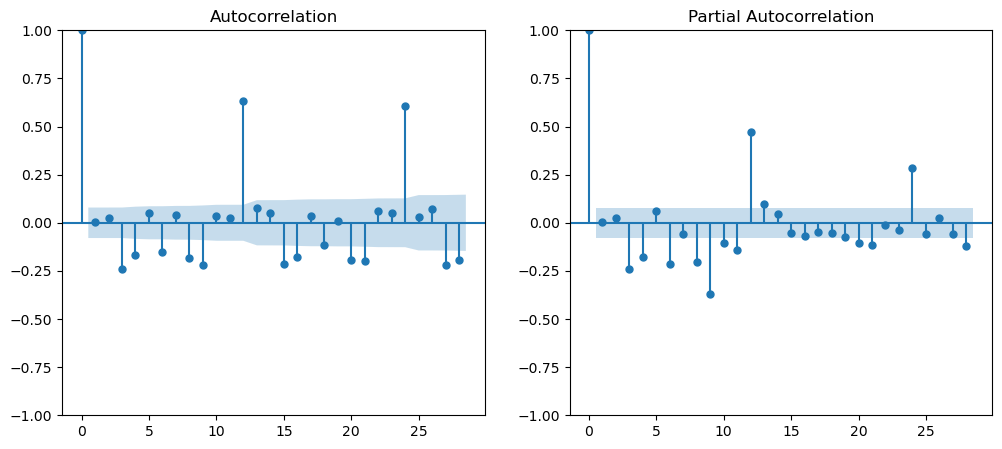

In [13]:
print("ACF and PACF for Diff_Log")
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plot_acf(df['Diff'].dropna(), ax=ax[0])
plot_pacf(df['Diff'].dropna(), ax=ax[1])
plt.show()

**Split Data Into Train/Test Set**

In [15]:
# Split data into training and test sets (80% training, 20% test)
train_size = int(len(df) * 0.8)  # 80% training, 20% testing
train_data = df.iloc[:train_size]  # Training data
test_data = df.iloc[train_size:]   # Test data

train_column = 'Boxcox' #for arima + sarima
train_column_holt = 'Total Renewable Energy' #for holt-winters

**HOLT-WINTERS MODEL**

In [17]:
# Fit the Holt-Winters model on the training data
holt_model = ExponentialSmoothing(train_data[train_column_holt], trend='add', seasonal='add', seasonal_periods=12).fit()

# Forecast the next 12 periods (for the test set)
holt_forecast = holt_model.forecast(steps=len(test_data))

# Calculate MAPE and RMSE for Holt-Winters
mape_holt = mean_absolute_percentage_error(test_data[train_column_holt], holt_forecast)
rmse_holt = np.sqrt(mean_squared_error(test_data[train_column_holt], holt_forecast))

# Print the results
print(f"Holt-Winters MAPE: {mape_holt}")
print(f"Holt-Winters RMSE: {rmse_holt}")


Holt-Winters MAPE: 0.19575808372105896
Holt-Winters RMSE: 54.78349969893877


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


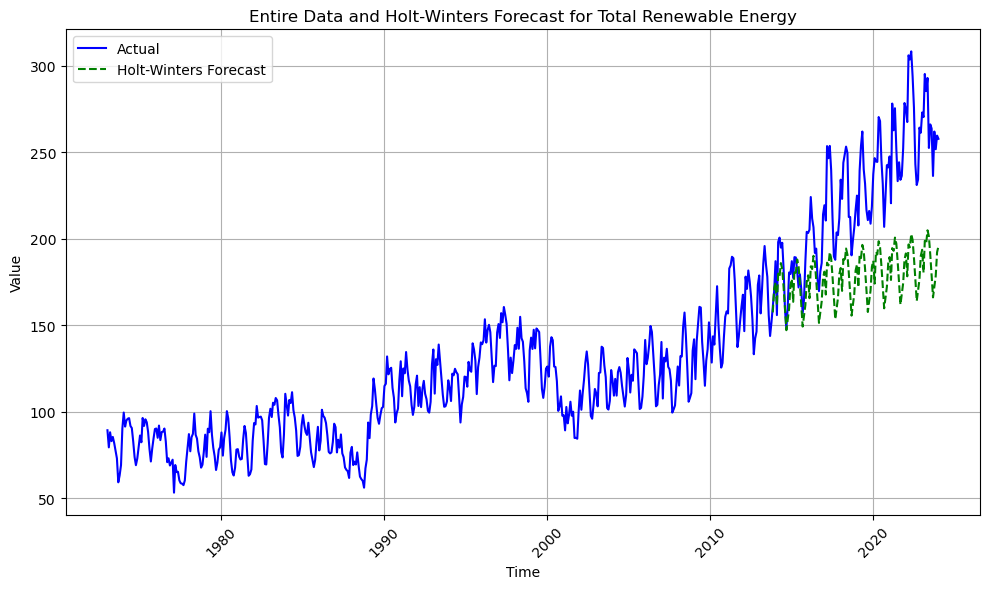

In [18]:
import matplotlib.pyplot as plt

# Plot the entire data and the forecasted values
plt.figure(figsize=(10, 6))

# Plot actual values (entire dataset)
plt.plot(df.index, df[train_column_holt], label="Actual", color="blue")

# Plot Holt-Winters forecasts (forecasting the next 24 periods, for example)
plt.plot(test_data.index, holt_forecast, label="Holt-Winters Forecast", color="green", linestyle="--")

# Customize the plot
plt.title(f"Entire Data and Holt-Winters Forecast for {train_column_holt}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

**ARIMA MODEL**

In [20]:
# Fit ARIMA on Boxcox-transformed data
model = ARIMA(train_data['Boxcox'], order=(2, 1, 2)).fit()
arima_boxcox_forecast = model.forecast(len(test_data))

# Calculate MAPE and RMSE in Boxcox scale
mape_arima_boxcox = mean_absolute_percentage_error(test_data['Boxcox'], arima_boxcox_forecast)
rmse_arima_boxcox = np.sqrt(mean_squared_error(test_data['Boxcox'], arima_boxcox_forecast))

print(f"ARIMA MAPE (Boxcox scale): {mape_arima_boxcox}")
print(f"ARIMA RMSE (Boxcox scale): {rmse_arima_boxcox}")

ARIMA MAPE (Boxcox scale): 0.017492722387102942
ARIMA RMSE (Boxcox scale): 0.04139746543041273


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [21]:
# Inverse transform with the correct lambda
lam = -0.4179508579342307  # Use the original lambda
arima_forecast = inv_boxcox(arima_boxcox_forecast, lam)

# Calculate MAPE and RMSE in original scale
mape_arima_original = mean_absolute_percentage_error(test_data['Total Renewable Energy'], arima_forecast)
rmse_arima_original = np.sqrt(mean_squared_error(test_data['Total Renewable Energy'], arima_forecast))

print(f"ARIMA MAPE (Original scale): {mape_arima_original}")
print(f"ARIMA RMSE (Original scale): {rmse_arima_original}")

ARIMA MAPE (Original scale): 0.27868795368786564
ARIMA RMSE (Original scale): 76.44999794155297


**SARIMA MODEL**

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data['Boxcox'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()
sarima_boxcox_forecast = model.forecast(len(test_data))
sarima_forecast = inv_boxcox(sarima_boxcox_forecast, lam)

mape_sarima = mean_absolute_percentage_error(test_data['Total Renewable Energy'], sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test_data['Total Renewable Energy'], sarima_forecast))


print(f"SARIMA MAPE: {mape_sarima}")
print(f"SARIMA RMSE: {rmse_sarima}")

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10748D+00    |proj g|=  2.64947D+01


 This problem is unconstrained.



At iterate    5    f= -3.13819D+00    |proj g|=  9.76629D-02

At iterate   10    f= -3.13845D+00    |proj g|=  2.83591D+00

At iterate   15    f= -3.14738D+00    |proj g|=  5.88212D+00

At iterate   20    f= -3.14964D+00    |proj g|=  3.25794D+00

At iterate   25    f= -3.16523D+00    |proj g|=  1.07572D-01

At iterate   30    f= -3.16979D+00    |proj g|=  5.43589D+00

At iterate   35    f= -3.19747D+00    |proj g|=  4.31657D-01

At iterate   40    f= -3.19749D+00    |proj g|=  1.49458D-01

At iterate   45    f= -3.19803D+00    |proj g|=  2.23495D-01

At iterate   50    f= -3.19898D+00    |proj g|=  1.84785D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Comparison of Models**

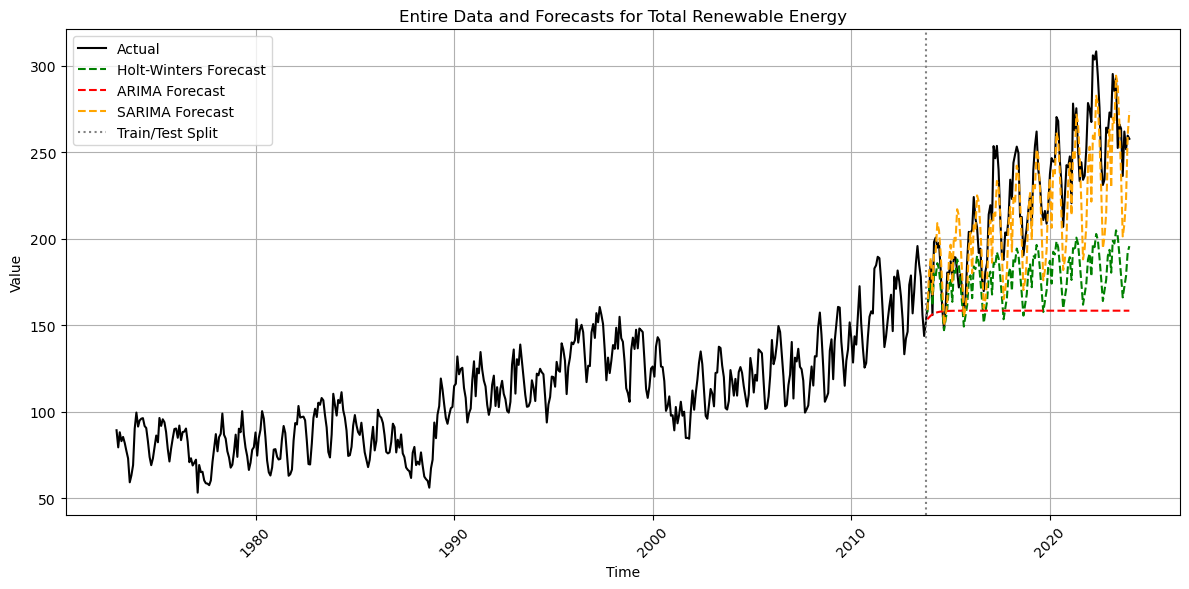

In [65]:
import matplotlib.pyplot as plt

# Plot the entire data and the forecasted values
plt.figure(figsize=(12, 6))  # Slightly wider for clarity

# Plot actual values (entire dataset)
plt.plot(df.index, df[train_column_holt], label="Actual", color="black")

# Plot Holt-Winters forecasts
plt.plot(test_data.index, holt_forecast, label="Holt-Winters Forecast", color="green", linestyle="--")

# Plot ARIMA forecasts
plt.plot(test_data.index, arima_forecast, label="ARIMA Forecast", color="red", linestyle="--")

# Plot SARIMA forecasts
plt.plot(test_data.index, sarima_forecast, label="SARIMA Forecast", color="orange", linestyle="--")

# Customize the plot
plt.title(f"Historical Data and Forecasts for {train_column_holt}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.axvline(x=train_data.index[-1], color='gray', linestyle=':', label='Train/Test Split')
plt.legend()

# Show the plot
plt.show()

In [26]:
models = [
    ('ARIMA', mape_arima_original, rmse_arima_original),
    ('SARIMA', mape_sarima, rmse_sarima),
    ('Holt-Winters', mape_holt, rmse_holt)
]

# Print table
print("Model Performance Comparison (Original Scale)")
print("-" * 40)
print(f"{'Model':<15} {'MAPE':>8} {'RMSE':>8}")
print("-" * 40)

for model, mape, rmse in models:
    print(f"{model:<15} {mape:>8.2%} {rmse:>8.2f}")

Model Performance Comparison (Original Scale)
----------------------------------------
Model               MAPE     RMSE
----------------------------------------
ARIMA             27.87%    76.45
SARIMA             7.81%    22.31
Holt-Winters      19.58%    54.78


**Future Forecasts**

**ARIMA FUTURE**

In [52]:
# Train on full dataset (Boxcox scale)
future_arima_model = ARIMA(df['Boxcox'], order=(2, 1, 2)).fit()

# Forecast 48 months beyond the last date
n_future = 48
arima_boxcox_future = future_arima_model.forecast(steps=n_future)
lam = -0.4179508579342307  # Your lambda
arima_future = inv_boxcox(arima_boxcox_future, lam)

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='MS')[1:]  # Monthly start

# Combine into a Series
arima_future_series = pd.Series(arima_future, index=future_dates)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**SARIMA FUTURE**

In [55]:
# Train on full dataset (Boxcox scale)
future_sarima_model = SARIMAX(df['Boxcox'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()

# Forecast 48 months beyond
sarima_boxcox_future = future_sarima_model.forecast(steps=n_future)
sarima_future = inv_boxcox(sarima_boxcox_future, lam)

# Use same future dates
sarima_future_series = pd.Series(sarima_future, index=future_dates)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.18949D+00    |proj g|=  2.86562D+01


 This problem is unconstrained.



At iterate    5    f= -3.22100D+00    |proj g|=  9.68739D-02

At iterate   10    f= -3.22111D+00    |proj g|=  2.11223D+00

At iterate   15    f= -3.22830D+00    |proj g|=  1.06344D+01

At iterate   20    f= -3.23129D+00    |proj g|=  1.75305D+00

At iterate   25    f= -3.26169D+00    |proj g|=  2.48778D+00

At iterate   30    f= -3.26415D+00    |proj g|=  1.01744D-01

At iterate   35    f= -3.26889D+00    |proj g|=  1.50573D-01

At iterate   40    f= -3.26945D+00    |proj g|=  2.72261D-01

At iterate   45    f= -3.26946D+00    |proj g|=  1.29140D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47    136      3     0     0   1.284D-01  -3.269D+00
  F =  -3.2694598836089241     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


**HOLT-WINTERS FUTURE**

In [58]:
# Train on full dataset (original scale)
hw_model = ExponentialSmoothing(df['Total Renewable Energy'], seasonal_periods=12, trend='add', seasonal='add').fit()

# Forecast 48 months beyond
hw_future = hw_model.forecast(steps=n_future)

# Use same future dates
hw_future_series = pd.Series(hw_future, index=future_dates)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


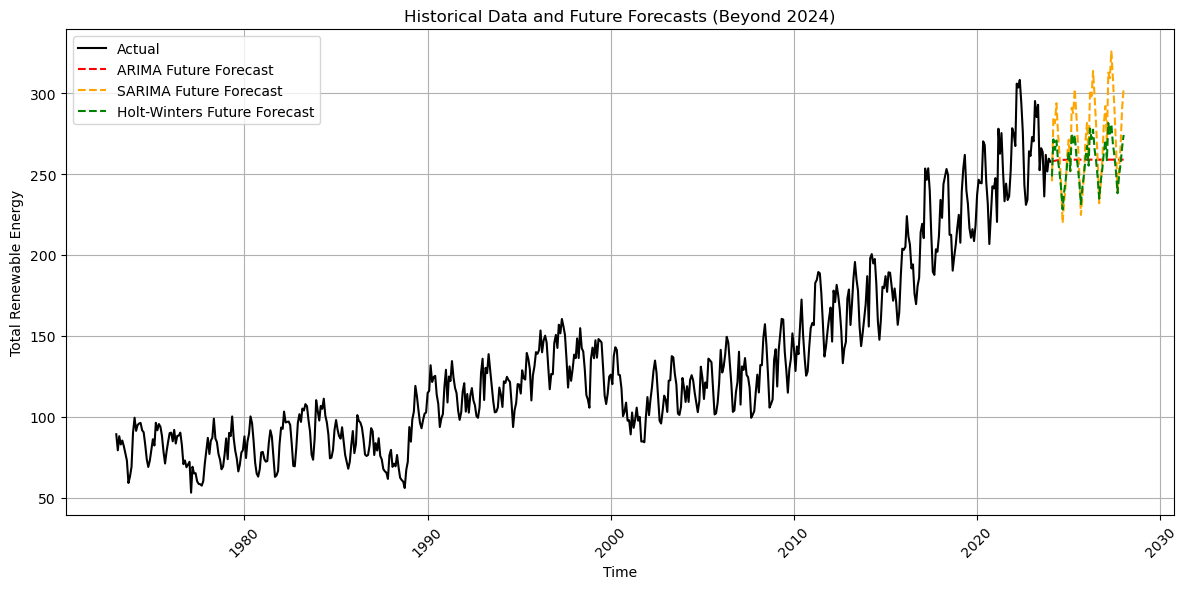

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df.index, df['Total Renewable Energy'], label="Actual", color="black")

# Plot future forecasts
plt.plot(future_dates, arima_future_series, label="ARIMA Future Forecast", color="red", linestyle="--")
plt.plot(future_dates, sarima_future_series, label="SARIMA Future Forecast", color="orange", linestyle="--")
plt.plot(future_dates, hw_future_series, label="Holt-Winters Future Forecast", color="green", linestyle="--")

# Customize
plt.title("Historical Data and Future Forecasts (Beyond 2024)")
plt.xlabel("Time")
plt.ylabel("Total Renewable Energy")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()